In [ ]:
#No85(双方向RNN・多層化)
#基本的にNo84と同じ
import pandas as pd
import re
import numpy as np

# 前処理があまいところがあったので、作成し直す
file = '/content/drive/MyDrive/newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# 単語の頻度
from collections import Counter
words = []
for text in train['TITLE']:
  #空文字で区切って、wordに追加していく
    for word in text.rstrip().split():
        words.append(word)
#数える
c = Counter(words)
#辞書の作成
word2id = {}
for i, cnt in enumerate(c.most_common()):
  ##出現頻度2回以上の単語のみ辞書に追加
    if cnt[1] > 1:
        word2id[cnt[0]] = i + 1
# 出現頻度上位10単語
for i, cnt in enumerate(word2id.items()):
    if i >= 10:
        break
    print(cnt[0], cnt[1])
# 単語のID化
def tokenizer(text):
    words = text.rstrip().split()
#単語辞書からそのwordのidを取得．ない場合は0を返す
    return [word2id.get(word, 0) for word in words]

0 1
to 2
in 3
on 4
UPDATE 5
The 6
as 7
for 8
To 9
of 10


In [ ]:
#modelの可視化
!pip install torchinfo
from torch import nn
import random
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary

# 乱数のシードを設定
# parserなどで指定
seed = 1234
random.seed(seed)
np.random.seed(seed)
#再現性を保つ
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#seed値の作成
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

from gensim.models import KeyedVectors

# 事前学習済みの単語ベクトル
file = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 2 #辞書のID数 + unknown + パディングID(ID化する単語の種類)
EMB_SIZE = 300 #埋め込みベクトルのサイズ
weights = np.zeros((VOCAB_SIZE, EMB_SIZE)) #学習済み単語ベクトルの初期化
words_in_pretrained = 0
#学習済み単語ベクトルの取得(単語が無いときは正規乱数で初期化)
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 4356 / 4598
torch.Size([4598, 300])


In [ ]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
print(Y_train.size())
print(Y_train)

class NewsDataset(data.Dataset):
    def __init__(self, X, y, phase='train'):
      #X: 単語ベクトルの平均をまとめたテンソル
      #y: カテゴリをラベル化したテンソル
        self.X = X['TITLE']
        self.y = y
        #学習か訓練かを設定する
        self.phase = phase

    def __len__(self):
        #全データサイズを返す
        return len(self.y)

    def __getitem__(self, idx):
        #idxに対応するテンソル形式のデータとラベルを取得
        inputs = torch.tensor(tokenizer(self.X[idx]))
        return inputs, self.y[idx]

train_dataset = NewsDataset(train, Y_train, phase='train')
valid_dataset = NewsDataset(valid, Y_valid, phase='val')
test_dataset = NewsDataset(test, Y_test, phase='val')
idx = 0


torch.Size([3709])
tensor([3, 1, 1,  ..., 2, 0, 0])


In [ ]:
#自動的にバッチ内の文章の最大単語数でそろえるようにする。
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.LongTensor([x[1] for x in batch])
    x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    return x, labels

# DataLoaderを作成
batch_size = 64

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,}


Tesla T4
Epoch 1 / 100 (train) Loss: 1.3192, Acc: 0.4314, (val) Loss: 1.2547, Acc: 0.4310
Epoch 2 / 100 (train) Loss: 1.2181, Acc: 0.4319, (val) Loss: 1.1908, Acc: 0.4310
Epoch 3 / 100 (train) Loss: 1.1757, Acc: 0.4335, (val) Loss: 1.1651, Acc: 0.4310
Epoch 4 / 100 (train) Loss: 1.1593, Acc: 0.4325, (val) Loss: 1.1563, Acc: 0.4310
Epoch 5 / 100 (train) Loss: 1.1538, Acc: 0.4322, (val) Loss: 1.1534, Acc: 0.4289
Epoch 6 / 100 (train) Loss: 1.1516, Acc: 0.4319, (val) Loss: 1.1521, Acc: 0.4289
Epoch 7 / 100 (train) Loss: 1.1505, Acc: 0.4314, (val) Loss: 1.1514, Acc: 0.4332
Epoch 8 / 100 (train) Loss: 1.1503, Acc: 0.4311, (val) Loss: 1.1510, Acc: 0.4353
Epoch 9 / 100 (train) Loss: 1.1496, Acc: 0.4314, (val) Loss: 1.1506, Acc: 0.4353
Epoch 10 / 100 (train) Loss: 1.1488, Acc: 0.4335, (val) Loss: 1.1501, Acc: 0.4332
Epoch 11 / 100 (train) Loss: 1.1485, Acc: 0.4335, (val) Loss: 1.1497, Acc: 0.4332
Epoch 12 / 100 (train) Loss: 1.1487, Acc: 0.4343, (val) Loss: 1.1493, Acc: 0.4353
Epoch 13 / 100 (

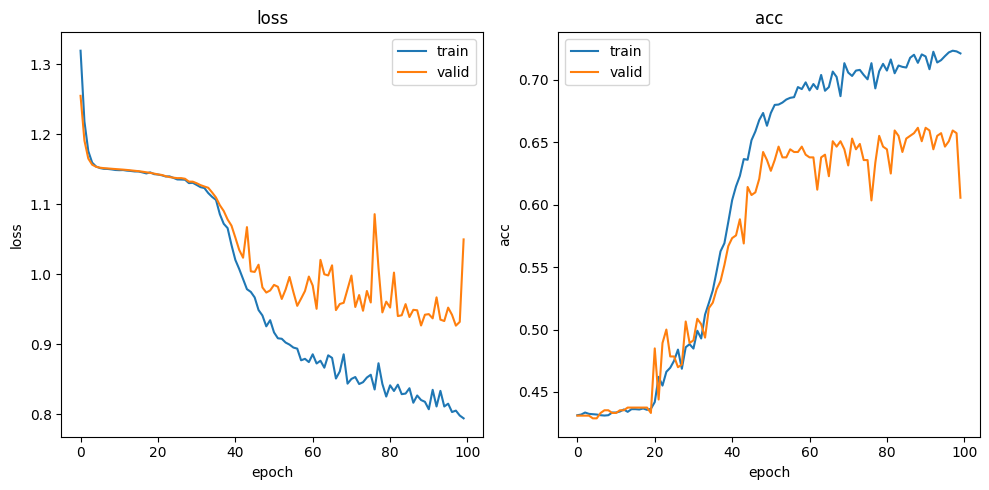

学習データの正解率: 0.6840
検証データの正解率: 0.6056
テストデータの正解率: 0.6595


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1, emb_weights=None):
        super().__init__()
        #重みがあれば、初期化
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
            #双方向RNN化するためには、bidirectional=Trueにする
            #入力するデータ系列の次元が(batch_size) が頭に来る
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        #hidden_sizeを2倍にするのを忘れない
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x, h0=None):
        x = self.emb(x)
        #予測ラベルxと次の隠れ状態
        x, h = self.rnn(x, h0)
        #最後の隠れ状態xの出力層
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
PADDING_IDX = len(set(word2id.values())) + 1 #各データの単語数を揃えるために空きを埋めるindex
OUTPUT_SIZE = 4  #分類するクラス数
HIDDEN_SIZE = 50 #RNNの隠れ層のサイズ
NUM_LAYERS = 1   #RNNの層数

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUを利用するようにする
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name())

    # ネットワークをGPUへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUを使用する
                inputs = inputs.to(device)
                labels = labels.to(device)
                # optimizerを初期化する
                optimizer.zero_grad()

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    # 損失を計算(outputとラベルをもとに)
                    loss = criterion(outputs, labels)
                    # ラベルを予想(最大値が予想ラベルとなる)
                    _, preds = torch.max(outputs, 1)

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        # パラメータ更新
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            #訓練時のepochごとのlossと正解率の保存
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            #検証時のeptchごとのlossと正解率の保存
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
#パラメーターがもしかしたらよくないかもしれない
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#100位が丁度よいと思われる
num_epochs = 100
train_loss_weights, train_acc_weights, valid_loss_weights, valid_acc_weights = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

#正解率を計算
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    #正しく予想できたものをデータの総数で割ると正解率が求まる
    return corrects / len(dataloader.dataset)
#結果の可視化
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss_weights, label='train')
ax[0].plot(epochs, valid_loss_weights, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc_weights, label='train')
ax[1].plot(epochs, valid_acc_weights, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/knock85.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))